Challenge
Do a little scraping or API-calling of your own. Pick a new website and see what you can get out of it. Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)

2) Iterate over multiple pages/queries

3) Save the data to your computer

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest. Write up a report from scraping code to summary and share it with your mentor.

In [5]:
# Importing in each cell because of the kernel restarts.
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.spiders import Rule
from scrapy.linkextractors import LinkExtractor


class CLSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "CL"
    
    # URL(s) to start with.
    allowed_domains = ["phoenix.craigslist.org"]
    start_urls = [
        'https://phoenix.craigslist.org/search/apa?query=tempe&min_bedrooms=1&max_bedrooms=1&min_bathrooms=1&max_bathrooms=1&availabilityMode=0&housing_type=1&laundry=1&parking=1&sale_date=all+dates',
    ]
    
    rules = (Rule (LinkExtractor(allow=("index\d00\.html", ),restrict_xpaths=('//p[@id="nextpage"]',)), callback="parse_items", follow= True),)

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for posting in response.xpath('//p'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'title': posting.xpath('a[@class="result-title hdrlnk"]/text()').extract_first(),
                'date': posting.xpath('time[@class="result-date"]/text()').extract_first(),
                'price': posting.xpath('span/span[@class="result-price"]/text()').extract_first()
            }
        
        # follow next page links
        next_page = response.xpath('.//a[@class="button next"]/@href').extract()
        if next_page:
            next_href = next_page[0]
            next_page_url = 'http://phoenix.craigslist.org' + next_href
            request = scrapy.Request(url=next_page_url)
            yield request  

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'tempe_apt.json',  # Name our storage file.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcamp (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(CLSpider)
process.start()
print('Success!')

Success!


In [6]:
import pandas as pd

# Turning JSON into Data Frame
df_apt = pd.read_json('tempe_apt.json')
print(df_apt.shape)
df_apt.head()


(1234, 3)


,date,price,title
0,Aug 26,$1360,"Pet Friendly, featuring a Large Pet Park and D..."
1,Aug 26,$1035,"Top of the Line Exercise Equipment, Private Ba..."
2,Aug 26,$1049,Great price in this local/Washer/Dryer Include...
3,Aug 26,$1256,"Offering up to one month free, Resort Inspired..."
4,Aug 26,$1077,Great price in this local/Washer/Dryer Included


# Obervation Specifications

- housing type: apartment
- bedroom count: one 
- washer and dryer in unit
- parking: carport

# Data Cleaning, Missingness

In [7]:
import re
 
# Scrub the dollar sign away
df_apt.price = df_apt.price.map(lambda x: None if x == None else int(re.sub('\$', '', str(x))))
df_apt.head()

,date,price,title
0,Aug 26,1360.0,"Pet Friendly, featuring a Large Pet Park and D..."
1,Aug 26,1035.0,"Top of the Line Exercise Equipment, Private Ba..."
2,Aug 26,1049.0,Great price in this local/Washer/Dryer Include...
3,Aug 26,1256.0,"Offering up to one month free, Resort Inspired..."
4,Aug 26,1077.0,Great price in this local/Washer/Dryer Included


In [8]:
# Check data types
df_apt.dtypes

date      object
price    float64
title     object
dtype: object

In [10]:
total_missing = df_apt.isnull().sum().sort_values(ascending=False) 
                    #find the total null data values in each column based on percentage of data points in each column 

percent_missing = (df_apt.isnull().sum()/df_apt.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data

,Total,Percent
title,2,0.001621
price,2,0.001621
date,2,0.001621


In [12]:
df_apt = df_apt.dropna()

# Analysis

In [33]:
print('Average Aparment Price: ${0:.4g}\n'.format(df_apt.price.mean()))
print('Apartment Price Standard Deviation: +/-${0:.3g}\n'.format(df_apt.price.std()))
print('Apartment Price Median: +/-${0:.4g}'.format(df_apt.price.median()))

Average Aparment Price: $1215

Apartment Price Standard Deviation: +/-$251

Apartment Price Median: +/-$1145


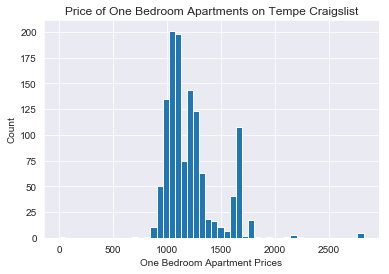

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

plt.hist(df_apt.price, bins=50)
plt.xlabel('One Bedroom Apartment Prices')
plt.ylabel('Count')
plt.title('Price of One Bedroom Apartments on Tempe Craigslist')
plt.show()

# Summary

Scrapy code worked quite well once I had the correct code written to follow the "next page" links, all of the data that could be scraped was collected, totaling 1234 observations. This allowed for a confident estimate of the average price of one bedroom apartments listed on the regional craigslist portal. I am confident I could easily apply this same method to compare apartment prices across multiple areas/cities.  